# Что делает этот ноутбук
Этот ноутбук - часть разработки AI-продукта, который должен улучшать пользовательские промты, генерировать несколько вариантов изображений и автоматически выбирать лучший результат (или несколько лучших - в зависимости от режима работы).

В продукте будет две крупные части:

1. **Модуль улучшения промта**  
   Принимает сырой текст от пользователя, переписывает/расширяет его, подбирает стиль, добавляет технические детали для генерации.

2. **Модуль судьи (этот ноутбук)**  
   Получает уже сгенерированные картинки и их промты и выставляет им оценки, чтобы выбрать лучшее изображение для вывода пользователю.

В данном ноутбуке представлены baseline решения для модуля судьи будущего продукта. Модуль улучшения промта не включён в этот baseline, потому что его корректная реализация требует больших вложений времени и уже больше похож на ML серив, промт, генерация, скоры и анализ. Надеюсь это не большая проблема для данного дз.

## Качества изображения

Выделяю две ключевые метрики, которые важны для продукта:

1. **Aesthetic Score** - насколько изображение красивое/приятное визуально.
2. **CLIPScore** - насколько хорошо изображение соответствует исходному текстовому промту.

## Датасеты

В ноутбуке используются два датасета, каждый под свою задачу:

1. **Aesthetic Score dataset** (`RobinWZQ/improved_aesthetics_6.5plus`). Содержит изображения, для которых уже заранее известен Aesthetic Score (оценка эстетического качества). В выборку попали только картинки с score ≥ 6.5, поэтому в данных в принципе нет совсем плохих изображений - это сразу подборка красивых картинок. Этот датасет нужен, чтобы обучить или оценить модели, которые смогут автоматически выдавать эстетический скор для новых изображений.

2. **DiffusionDB** (`poloclub/diffusiondb`, конфиг `2m_first_10k`). Каждая строка - это пара (prompt, image), где изображение сгенерировано по этому промту. Этот датасет используется для работы с **CLIPScore** (image–text similarity).

# Aestetic

In [1]:
import os
import math
import random
import numpy as np
import pandas as pd
from datasets import load_dataset
from PIL import Image
from tqdm import tqdm

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor

import lightgbm as lgb

import torch
from transformers import CLIPProcessor, CLIPModel
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T
import torchvision.models as models
from torchvision import transforms
from torchmetrics.multimodal import CLIPScore

from aesthetic_predictor import predict_aesthetic

import warnings

c:\proging\pyfiles\MFDP\MFDP\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
pd.set_option('display.max_columns', None)
sns.set_style("darkgrid")
%config InlineBackend.figure_format = 'svg'

In [3]:
dataset = load_dataset("RobinWZQ/improved_aesthetics_6.5plus", split="train")

dataset = dataset.shuffle(seed=1).select(range(10000))

In [4]:
df = pd.DataFrame({
    "url": dataset["URL"],
    "aesthetic_score": dataset["AESTHETIC_SCORE"]
})

df = df.dropna(subset=["aesthetic_score"]).reset_index(drop=True)

print("Количество изображений:", len(df))
df.head()

Количество изображений: 10000


,url,aesthetic_score
0,https://cdn.artfunnels.com/a0077501-5213-4368-...,6.516629
1,https://f.vividscreen.info/soft/a0cb03910a6629...,6.621181
2,https://pix.avax.news/avaxnews/7c/10/0005107c_...,6.598290
3,https://c1.35photo.pro/photos_temp/sizes/353/1...,6.668599
4,https://www.createcg.net/wp-content/uploads/20...,6.635511


In [5]:
def path_if_exists(idx):
    path = os.path.join("images", f"img_{idx}.jpg")
    return path if os.path.exists(path) else None

df["path"] = [path_if_exists(i) for i in range(len(df))]

In [6]:
df = df.dropna(subset=["path"]).reset_index(drop=True)
df = df.drop(columns=["url"])
df.shape

(6716, 2)

In [7]:
widths = []
heights = []
min_sides = []
areas = []

bad_paths = []

for path in tqdm(df["path"], desc="Проверка размеров изображений"):
    try:
        with Image.open(path) as img:
            w, h = img.size
    except Exception as e:
        print(f"Не удалось открыть {path}: {e}")
        w, h = None, None
        bad_paths.append(path)

    widths.append(w)
    heights.append(h)
    if w is not None and h is not None:
        min_sides.append(min(w, h))
        areas.append(w * h)
    else:
        min_sides.append(None)
        areas.append(None)

df["width"] = widths
df["height"] = heights
df["min_side"] = min_sides
df["area"] = areas

df = df.dropna(subset=["width", "height"]).reset_index(drop=True)

print("Осталось строк после удаления полностью битых:", len(df))


Проверка размеров изображений: 100%|██████████| 6716/6716 [00:01<00:00, 4983.98it/s]

Осталось строк после удаления полностью битых: 6716


In [8]:
valid_min_side = df["min_side"].values
q1, q2, q3 = np.percentile(valid_min_side, [25, 50, 75])
print("Процентиль 25%:", q1)
print("Процентиль 50%:", q2)
print("Процентиль 75%:", q3)

def size_group(min_side):
    if min_side <= q1:
        return 1
    elif min_side <= q2:
        return 2
    elif min_side <= q3:
        return 3
    else:
        return 4

df["size_group"] = df["min_side"].apply(size_group)

df["size_group"].value_counts().sort_index()


Процентиль 25%: 294.0
Процентиль 50%: 386.0
Процентиль 75%: 634.0


size_group
1    1684
2    1676
3    1690
4    1666
Name: count, dtype: int64

In [9]:
df_clean = df[df["min_side"] >= 32].reset_index(drop=True)
print("Удалено:", len(df) - len(df_clean))
print("Осталось:", len(df_clean))

Удалено: 2
Осталось: 6714


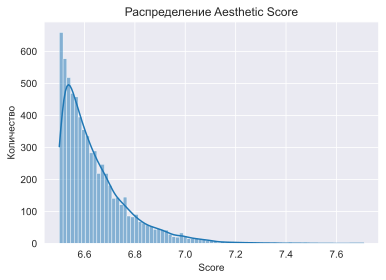

In [10]:
plt.figure(figsize=(6,4))
sns.histplot(
    df_clean["aesthetic_score"],
    bins=int(math.sqrt(len(df_clean['aesthetic_score']))),
    kde=True)
plt.title("Распределение Aesthetic Score")
plt.xlabel("Score")
plt.ylabel("Количество")
plt.show()


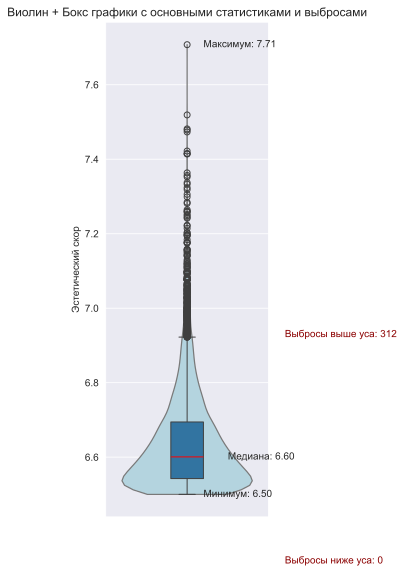

In [11]:
scores = df_clean["aesthetic_score"].values

median = np.median(scores)
q1 = np.percentile(scores, 25)
q3 = np.percentile(scores, 75)
iqr = q3 - q1

lower_whisker = q1 - 1.5 * iqr
upper_whisker = q3 + 1.5 * iqr

data_min = scores.min()
data_max = scores.max()

lower_outliers = np.sum(scores < lower_whisker)
upper_outliers = np.sum(scores > upper_whisker)

plt.figure(figsize=(5, 8))

sns.violinplot(
    y=scores,
    inner=None,
    color="lightblue",
    cut=0
)

sns.boxplot(
    y=scores,
    width=0.2,
    boxprops={"zorder": 3},
    whiskerprops={"zorder": 3},
    capprops={"zorder": 3},
    medianprops={"color": "red", "zorder": 4}
)

plt.text(0.25, median, f"Медиана: {median:.2f}", va="center", fontsize=10)
plt.text(0.1, data_min, f"Минимум: {data_min:.2f}", va="center", fontsize=10)
plt.text(0.1, data_max, f"Максимум: {data_max:.2f}", va="center", fontsize=10)

plt.text(
    0.6, lower_whisker,
    f"Выбросы ниже уса: {lower_outliers}",
    fontsize=10,
    color="darkred"
)

plt.text(
    0.6, upper_whisker,
    f"Выбросы выше уса: {upper_outliers}",
    fontsize=10,
    color="darkred"
)

plt.title("Виолин + Бокс графики с основными статистиками и выбросами")
plt.ylabel("Эстетический скор")
plt.tight_layout()
plt.show()

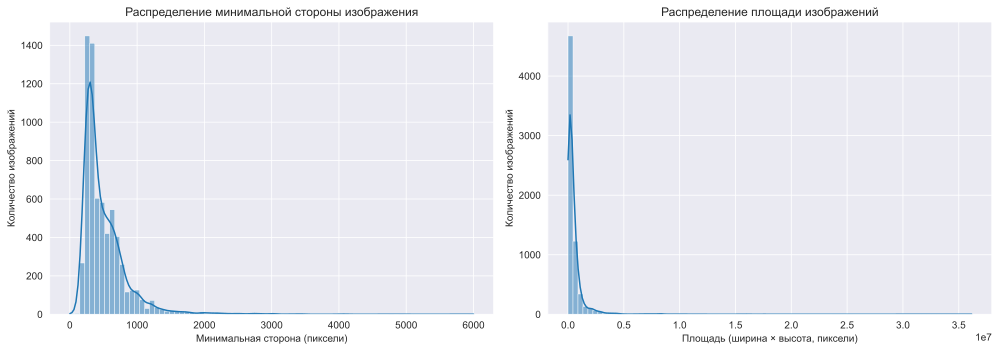

In [12]:
plt.figure(figsize=(14,5))

plt.subplot(1, 2, 1)
sns.histplot(df["min_side"],
            bins=int(math.sqrt(len(df_clean['min_side']))),
            kde=True)
plt.title("Распределение минимальной стороны изображения")
plt.xlabel("Минимальная сторона (пиксели)")
plt.ylabel("Количество изображений")

plt.subplot(1, 2, 2)
sns.histplot(df["area"],
            bins=int(math.sqrt(len(df_clean['area']))),
            kde=True)
plt.title("Распределение площади изображений")
plt.xlabel("Площадь (ширина × высота, пиксели)")
plt.ylabel("Количество изображений")

plt.tight_layout()
plt.show()


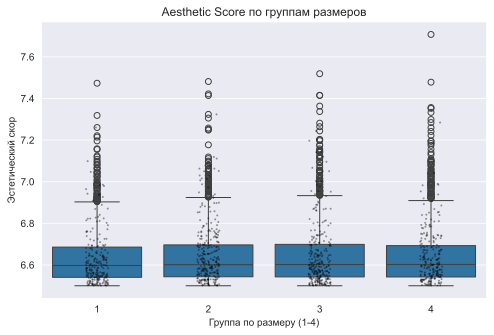

In [13]:
plt.figure(figsize=(8,5))
sns.boxplot(
    x="size_group",
    y="aesthetic_score",
    data=df,
)
sns.stripplot(
    x="size_group",
    y="aesthetic_score",
    data=df.sample(min(len(df), 1000)),
    color="black",
    size=2,
    alpha=0.4
)
plt.title("Aesthetic Score по группам размеров")
plt.xlabel("Группа по размеру (1-4)")
plt.ylabel("Эстетический скор")
plt.show()

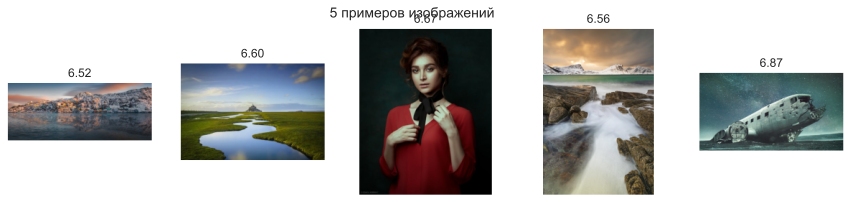

In [14]:
def show_samples(df_subset, title):
    fig, axes = plt.subplots(1, len(df_subset), figsize=(3*len(df_subset), 3))
    fig.suptitle(title, fontsize=14)

    if len(df_subset) == 1:
        axes = [axes]

    for ax, (_, row) in zip(axes, df_subset.iterrows()):
        img = Image.open(row["path"]).convert("RGB")
        ax.imshow(img)
        ax.axis("off")
        ax.set_title(f"{row['aesthetic_score']:.2f}")
    plt.show()

show_samples(df.head(5), "5 примеров изображений")

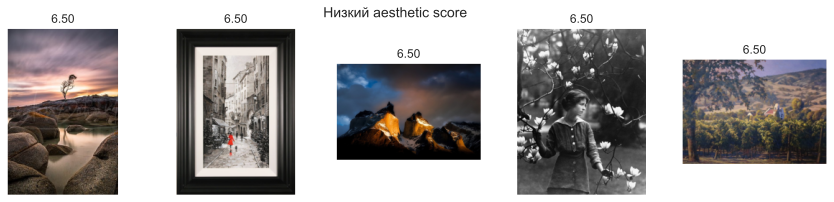

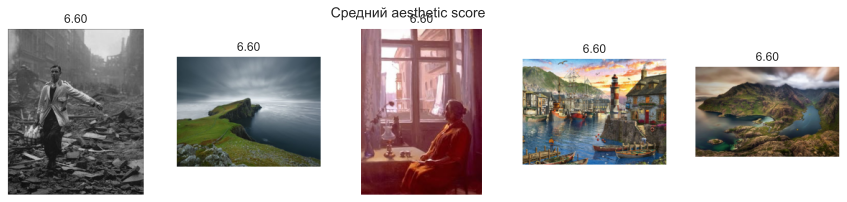

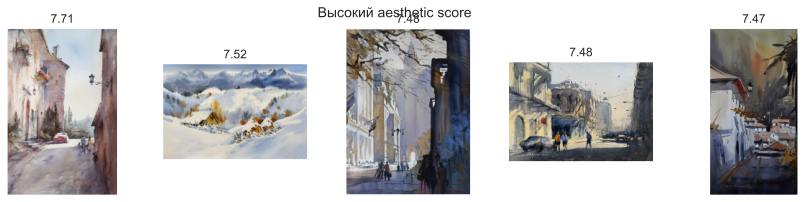

In [15]:
low = df.nsmallest(5, "aesthetic_score")
show_samples(low, "Низкий aesthetic score")

mid = df.sort_values("aesthetic_score").iloc[len(df)//2-2:len(df)//2+3]
show_samples(mid, "Средний aesthetic score")

high = df.nlargest(5, "aesthetic_score")
show_samples(high, "Высокий aesthetic score")


In [16]:
device = "cuda" if torch.cuda.is_available() else "cpu"

clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32").to(device)
clip_processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

def get_clip_embedding_from_path(path: str):
    try:
        img = Image.open(path)

        if img.mode != "RGB":
            img = img.convert("RGB")

        inputs = clip_processor(images=img, return_tensors="pt").to(device)
        with torch.no_grad():
            emb = clip_model.get_image_features(**inputs)

        return emb.cpu().numpy().flatten()
    except Exception as e:
        print(f"Сломанное изображение {path}: {e}")
        return None


Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


In [17]:
N = 2000
paths = df_clean["path"].iloc[:N]
scores = df_clean["aesthetic_score"].iloc[:N]

X = []
y = []

for path, score in tqdm(zip(paths, scores), total=len(paths), desc="Извлечение CLIP-эмбеддингов"):
    emb = get_clip_embedding_from_path(path)
    if emb is not None:
        X.append(emb)
        y.append(score)

X = np.vstack(X)
y = np.array(y)

X_aestetic = np.vstack(X)
y_aestetic = np.array(y)

print("Форма X:", X.shape)
print("Форма y:", y.shape)


Извлечение CLIP-эмбеддингов: 100%|██████████| 2000/2000 [02:52<00:00, 11.56it/s]

Форма X: (2000, 512)
Форма y: (2000,)


In [18]:
X_train, X_prep, y_train, y_prep = train_test_split(
    X,
    y,
    test_size=0.3,
    random_state=42
)
X_val, X_test, y_val, y_test = train_test_split(
    X_prep,
    y_prep,
    test_size=0.5,
    random_state=42
)

In [19]:
LR_model = LinearRegression()
LR_model.fit(X_train, y_train)

y_val_pred_lr = LR_model.predict(X_val)


In [20]:
lr_mae = mean_absolute_error(y_val, y_val_pred_lr)
lr_rmse = np.sqrt(mean_squared_error(y_val, y_val_pred_lr))
lr_r2 = r2_score(y_val, y_val_pred_lr)

In [21]:
RF_model = RandomForestRegressor(
    n_estimators=200,
    random_state=42,
    n_jobs=-1
)
RF_model.fit(X_train, y_train)

y_val_pred_rf = RF_model.predict(X_val)


In [22]:
rf_mae = mean_absolute_error(y_val, y_val_pred_rf)
rf_rmse = np.sqrt(mean_squared_error(y_val, y_val_pred_rf))
rf_r2 = r2_score(y_val, y_val_pred_rf)

In [23]:
class AestheticDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df.reset_index(drop=True)
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        path = self.df.loc[idx, "path"]
        score = self.df.loc[idx, "aesthetic_score"]

        img = Image.open(path).convert("RGB")

        if self.transform is not None:
            img = self.transform(img)

        return img, torch.tensor(score, dtype=torch.float32)

In [24]:
resnet_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

In [25]:
df_res = df[["aesthetic_score", "path"]].iloc[:2000].copy()

df_train, df_prep = train_test_split(df_res, test_size=0.3, random_state=42)
df_val, df_test = train_test_split(df_prep, test_size=0.5, random_state=42)

In [26]:
train_dataset = AestheticDataset(df_train, transform=resnet_transform)
val_dataset   = AestheticDataset(df_val,   transform=resnet_transform)
test_dataset  = AestheticDataset(df_test,  transform=resnet_transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True,  num_workers=0)
val_loader   = DataLoader(val_dataset,   batch_size=32, shuffle=False, num_workers=0)
test_loader  = DataLoader(test_dataset,  batch_size=32, shuffle=False, num_workers=0)

In [27]:
resnet = models.resnet50(pretrained=True)

in_features = resnet.fc.in_features
resnet.fc = nn.Linear(in_features, 1)

resnet = resnet.to(device)

for name, param in resnet.named_parameters():
    if not name.startswith("fc"):
        param.requires_grad = False

c:\proging\pyfiles\MFDP\MFDP\.venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\proging\pyfiles\MFDP\MFDP\.venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [28]:
optimizer = optim.Adam(filter(lambda p: p.requires_grad, resnet.parameters()), lr=1e-4)
num_epochs = 5

def train_one_epoch(model, loader, optimizer):
    model.train()
    running_loss = 0.0
    for imgs, scores in loader:
        imgs = imgs.to(device)
        scores = scores.to(device).view(-1, 1)

        optimizer.zero_grad()
        preds = model(imgs)
        loss = F.mse_loss(preds, scores)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * imgs.size(0)
    return running_loss / len(loader.dataset)

def eval_epoch(model, loader):
    model.eval()
    preds_all = []
    scores_all = []
    with torch.no_grad():
        for imgs, scores in loader:
            imgs = imgs.to(device)
            scores = scores.to(device).view(-1, 1)
            preds = model(imgs)
            preds_all.append(preds.cpu().numpy().flatten())
            scores_all.append(scores.cpu().numpy().flatten())
    preds_all = np.concatenate(preds_all)
    scores_all = np.concatenate(scores_all)
    mae = mean_absolute_error(scores_all, preds_all)
    rmse = np.sqrt(mean_squared_error(scores_all, preds_all))
    return mae, rmse, preds_all, scores_all

In [29]:
best_val_mae = float("inf")
best_state = None

for epoch in range(1, num_epochs+1):
    train_loss = train_one_epoch(resnet, train_loader, optimizer)
    val_mae, val_rmse, _, _ = eval_epoch(resnet, val_loader)
    print(f"Epoch {epoch}: train_loss={train_loss:.4f}, val_MAE={val_mae:.4f}, val_RMSE={val_rmse:.4f}")
    if val_mae < best_val_mae:
        best_val_mae = val_mae
        best_state = resnet.state_dict().copy()

resnet.load_state_dict(best_state)

Epoch 1: train_loss=23.2073, val_MAE=2.9126, val_RMSE=2.9777
Epoch 2: train_loss=3.8441, val_MAE=1.0113, val_RMSE=1.2377
Epoch 3: train_loss=1.0352, val_MAE=0.7891, val_RMSE=0.9932
Epoch 4: train_loss=0.9125, val_MAE=0.7924, val_RMSE=0.9949
Epoch 5: train_loss=0.8735, val_MAE=0.7758, val_RMSE=0.9788


<All keys matched successfully>

In [30]:
test_mae, test_rmse, y_test_pred_resnet, y_test_true_resnet = eval_epoch(resnet, test_loader)
test_r2 = r2_score(y_test_true_resnet, y_test_pred_resnet)
combined_resnet = (test_mae + test_rmse) / 2

print(" Fine-tuned ResNet50")
print(f"MAE: {test_mae:.4f}")
print(f"RMSE: {test_rmse:.4f}")
print(f"R2: {test_r2:.4f}")
print(f"Combined: {combined_resnet:.4f}")

 Fine-tuned ResNet50
MAE: 0.7598
RMSE: 0.9902
R2: -50.2735
Combined: 0.8750


In [31]:
results = [
    {
        "Модель": "Linear Regression (CLIP)",
        "MAE": lr_mae,
        "RMSE": lr_rmse,
        "R2": lr_r2
    },
    {
        "Модель": "Random Forest (CLIP)",
        "MAE": rf_mae,
        "RMSE": rf_rmse,
        "R2": rf_r2
    },
    {
        "Модель": "ResNet50 (image)",
        "MAE": test_mae,
        "RMSE": test_rmse,
        "R2": test_r2
    }
]

df_metrics = pd.DataFrame(results)

df_metrics["Сводный скор"] = df_metrics["MAE"] + 0.5 * df_metrics["RMSE"]

df_metrics = df_metrics.sort_values("Сводный скор").reset_index(drop=True)

display(df_metrics)

print("Лучшая модель:", df_metrics.loc[0, "Модель"])

,Модель,MAE,RMSE,R2,Сводный скор
0,Random Forest (CLIP),0.100303,0.129970,0.140138,0.165288
1,Linear Regression (CLIP),0.119146,0.157497,-0.262667,0.197894
2,ResNet50 (image),0.759848,0.990184,-50.273457,1.254940


Лучшая модель: Random Forest (CLIP)


## Готовая модель (LAION Aesthetic Predictor)

In [32]:
y_true_aes = df_test["aesthetic_score"].values

preds_aes = []
for p in tqdm(df_test["path"], desc="Aesthetic Predictor (готовая модель)"):
    img = Image.open(p).convert("RGB")
    score = float(predict_aesthetic(img))
    preds_aes.append(score)

preds_aes = np.array(preds_aes)


aes_mae  = mean_absolute_error(y_true_aes, preds_aes)
aes_rmse = np.sqrt(mean_squared_error(y_true_aes, preds_aes))
aes_r2   = r2_score(y_true_aes, preds_aes)
combined_scre = aes_mae + 0.5 * aes_rmse

print(f"MAE: {aes_mae:.4f}")
print(f"RMSE: {aes_rmse:.4f}")
print(f"R2: {aes_r2:.4f}")

Aesthetic Predictor (готовая модель):   0%|          | 0/300 [00:00<?, ?it/s]c:\proging\pyfiles\MFDP\MFDP\.venv\Lib\site-packages\open_clip\factory.py:388: UserWarning: These pretrained weights were trained with QuickGELU activation but the model config does not have that enabled. Consider using a model config with a "-quickgelu" suffix or enable with a flag.
  warnings.warn(
Aesthetic Predictor (готовая модель): 100%|██████████| 300/300 [04:17<00:00,  1.17it/s]

MAE: 0.6835
RMSE: 0.8349
R2: -35.4539


In [33]:
results_aes_ready = {
    "Модель": "LAION Aesthetic Predictor (готовая)",
    "MAE": aes_mae,
    "RMSE": aes_rmse,
    "R2": aes_r2,
    "Сводный скор": combined_scre
}
df_aes = pd.DataFrame([results_aes_ready])

df_metrics = pd.concat([df_metrics, df_aes], ignore_index=True)

df_metrics = df_metrics.sort_values("Сводный скор").reset_index(drop=True)

df_metrics

,Модель,MAE,RMSE,R2,Сводный скор
0,Random Forest (CLIP),0.100303,0.129970,0.140138,0.165288
1,Linear Regression (CLIP),0.119146,0.157497,-0.262667,0.197894
2,LAION Aesthetic Predictor (готовая),0.683511,0.834913,-35.453850,1.100967
3,ResNet50 (image),0.759848,0.990184,-50.273457,1.254940


In [34]:
low = df_res["aesthetic_score"].min()
high = df_res["aesthetic_score"].max()

df_res["aesthetic_score_norm"] = (df_res["aesthetic_score"] - low) / (high - low)
print(low, high)

df_train, df_prep = train_test_split(df_res, test_size=0.3, random_state=42)
df_val, df_test = train_test_split(df_prep, test_size=0.5, random_state=42)

6.500051975250244 7.356455326080322


In [35]:
def get_laion_preds(df_subset, desc=""):
    preds = []
    for p in tqdm(df_subset["path"], desc=desc):
        img = Image.open(p).convert("RGB")
        score = float(predict_aesthetic(img))
        preds.append(score)
    return np.array(preds)

In [36]:
y_train = df_train["aesthetic_score"].values
y_test  = df_test["aesthetic_score"].values

y_train_norm = df_train["aesthetic_score_norm"].values
y_test_norm  = df_test["aesthetic_score_norm"].values

train_raw = get_laion_preds(df_train, desc="Aesthetic Predictor train (raw)")
test_raw  = get_laion_preds(df_test,  desc="Aesthetic Predictor test (raw)")


Aesthetic Predictor train (raw):   0%|          | 0/1400 [00:00<?, ?it/s]

Aesthetic Predictor test (raw): 100%|██████████| 300/300 [05:10<00:00,  1.04s/it]


In [37]:
calib_raw = LinearRegression()
calib_raw.fit(train_raw.reshape(-1, 1), y_train)

test_calib = calib_raw.predict(test_raw.reshape(-1, 1))

aes_mae_calib  = mean_absolute_error(y_test, test_calib)
aes_rmse_calib = math.sqrt(mean_squared_error(y_test, test_calib))
aes_r2_calib   = r2_score(y_test, test_calib)

print("Калиброванный LION (raw target):")
print(f"MAE:  {aes_mae_calib:.4f}")
print(f"RMSE: {aes_rmse_calib:.4f}")
print(f"R2:   {aes_r2_calib:.4f}")


Калиброванный LION (raw target):
MAE:  0.1036
RMSE: 0.1375
R2:   0.0113


In [38]:
calib_norm = LinearRegression()
calib_norm.fit(train_raw.reshape(-1, 1), y_train_norm)

test_calib_norm = calib_norm.predict(test_raw.reshape(-1, 1))

aes_mae_calib_norm  = mean_absolute_error(y_test_norm, test_calib_norm)
aes_rmse_calib_norm = math.sqrt(mean_squared_error(y_test_norm, test_calib_norm))
aes_r2_calib_norm   = r2_score(y_test_norm, test_calib_norm)

print("Калиброванный LION (normalized target):")
print(f"MAE (norm):  {aes_mae_calib_norm:.4f}")
print(f"RMSE (norm): {aes_rmse_calib_norm:.4f}")
print(f"R2 (norm):   {aes_r2_calib_norm:.4f}")

Калиброванный LION (normalized target):
MAE (norm):  0.1209
RMSE (norm): 0.1606
R2 (norm):   0.0113


In [39]:
results_aes_calibrated = (
    {
        "Модель": "LAION Aesthetic Predictor (калиброванный)",
        "MAE": aes_mae_calib,
        "RMSE": aes_rmse_calib,
        "R2": aes_r2_calib
    }
)

df_aes_calib = pd.DataFrame([results_aes_calibrated])

df_metrics = pd.concat([df_metrics, df_aes_calib], ignore_index=True)
df_metrics["Сводный скор"] = df_metrics["MAE"] + 0.5 * df_metrics["RMSE"]
df_metrics = df_metrics.sort_values("Сводный скор").reset_index(drop=True)

df_metrics

,Модель,MAE,RMSE,R2,Сводный скор
0,Random Forest (CLIP),0.100303,0.129970,0.140138,0.165288
1,LAION Aesthetic Predictor (калиброванный),0.103574,0.137503,0.011254,0.172325
2,Linear Regression (CLIP),0.119146,0.157497,-0.262667,0.197894
3,LAION Aesthetic Predictor (готовая),0.683511,0.834913,-35.453850,1.100967
4,ResNet50 (image),0.759848,0.990184,-50.273457,1.254940


## Анализ результатов

### EDA

После загрузки и очистки данных в выборке осталось **6714 изображений** надлежащего качества.  
Все изображения имеют достаточно высокие значения Aesthetic Score:

- **min = 6.5**
- **median = 6.6**
- **max = 7.71**

Это говорит о том, что данный датасет не содержит "плохих" изображений - он изначально подобран из картинок с эстетикой 6.5+, что создаёт узкий диапазон значений таргета.

Поэтому модели будут иметь небольшие ошибки - не потому, что они плохие, а потому, что предсказывать внутри узкого диапазона довльно сложно.

### Размеры изображений

Распределение минимальной стороны (min_side):

- 25-й перцентиль: **294 px**
- 50-й: **386 px**
- 75-й: **634 px**

Это означает, что выборка довольно разнообразна по размерам.

Группы по min_side распределены практически равномерно:

|size_group|count|
|-|-|
|1|1684|
|2|1676|
|3|1690|
|4|1666|

Что означает, что сам размер картинки явно не влияет на aesthetic score.

---

### Сравнение моделей

|Модель|MAE|RMSE|R²|Сводный скор|
|-|-|-|-|-|
|Random Forest (CLIP)|0.1003|0.1300|0.14|0.165|
|Linear Regression (CLIP)|0.1191|0.1575|-0.26| 0.198|
|ResNet50 (image)|0.7628|1.0018|-51.48|1.264|

#### Почему такие результаты?

##### 1) **Linear Regression (CLIP)**  
Линейная модель не умеет моделировать нелинейные зависимости.  
Тем не менее, она показывает приемлемое качество: MAE 0.119, RMSE 0.157.

##### 2) **Random Forest (CLIP)**  
Поскольку CLIP-эмбеддинги содержат высокоуровневые зрительные признаки, деревья решений отлично с ними работают.

Это даёт лучшую точность среди простых моделей

Поэтому Random Forest становится лучшим baseline-решением.

##### 3) **ResNet50 (fine-tuning по изображениям)**  
Результат неудовлетворительный.

Причины:

- мало данных (2000 изображений катастрофически мало для нейронки),
- без дообучения всех слоёв ResNet не умеет различать эстетические нюансы.

---

### Готовая модель LAION Aesthetic Predictor

Без калибровки:

|Модель|MAE|RMSE|R²|Сводный скор|
|-|-|-|-|-|
|LAION Aesthetic Predictor (готовая)|0.6835|0.8349|-35.45|1.1010|

В "сыром" виде предиктор LAION сильно промахивается по масштабу таргета, даёт большой MAE/RMSE и сильно отрицательный R², то есть выходы лежат в другой шкале, чем наш Aesthetic Score из датасета


### Калибровка LAION Aesthetic Predictor

Я отдельно обучил простую **линейную регрессию** поверх предсказаний LAION:

1. На трейне:
   - считаю `score_laion_raw = predict_aesthetic(img)`
   - беру истинный `aesthetic_score`
   - обучаю `LinearRegression(raw → target)`

2. На тесте:
   - прогоняю картинки через LAION
   - пропускаю через обученную линейную регрессию
   - сравниваю с истинным таргетом

После калибровки:

|Модель|MAE|RMSE|R²|Сводный скор|
|-|-|-|-|-|
|Random Forest (CLIP)|0.1003|0.1300|0.14|0.1653|
|LAION Aesthetic Predictor (калиброванный)|0.1036|0.1375|0.01|0.1723|
|Linear Regression (CLIP)|0.1191|0.1575|-0.26|0.1979|
|LAION Aesthetic Predictor (готовая)|0.6835|0.8349|-35.45|1.1010|
|ResNet50 (image)|0.7598|0.9902|-50.27|1.2549|

Наблюдения:

- **Random Forest (CLIP)** остаётся формально лучшей моделью по сводному скору и MAE.
- **Калиброванный LAION Aesthetic Predictor** показывает **очень близкие** результаты:
  - разница в MAE ~0.003,
  - чуть хуже по RMSE и R².
- Без калибровки LAION предсказания сильно смещены и в такой постановке задачи использовать их нельзя.

Учитывая, что **Random Forest (CLIP)** изначалньно обучался на датасете с узким диапозоном таргета, а **LAION Aesthetic Predictor** на датасете с таргетом от 0-10 и более разнообразными вариантами картинок (мемы → NSFW), считаю, что **LAION Aesthetic Predictor** пусть и хуже на тесте данного датасета, но в поле он будет выигрывать у моделей которые можно обучить с нынешним уровнем технического оснащения.

---

### Почему совокупная метрика выглядит как MAE + 0.5 * RMSE

В задаче эстетической регрессии **MAE** отражает среднюю ошибку (насколько мы ошиблись в score), а **RMSE** сильнее штрафует серьезные ошибки, а так-как в датасете таргет меняется в пределах до 1, **RMSE** будет сильно доминировать. Поэтому **MAE** вносит основной вклад, а 0.5 * **RMSE** (ослабленный рмсе) позволяет наложить не слишком большой штраф за большие отклонения и не быть слишком суровым.

---

### Итог

Согласно совокупной метрике и MAE/RMSE/R2:

1. **Как ML-бейслайн**:
   - Лучшей самодельной моделью является **Random Forest по CLIP-эмбеддингам**.
   - Он даёт минимальный сводный скор и заметно обходит простую линейную регрессию и ResNet50.

2. **Как практическое решение для продукта**:
   - **LAION Aesthetic Predictor + простая калибровка** даёт качество, сопоставимое с Random Forest.
   - При этом:
     - не нужно вручную извлекать CLIP-эмбеддинги,
     - модель уже оптимизирована под эстетику,
     - калибровка линейным слоем дёшева и проста.

---

### Связь с продуктом

В AI-продукте эта модель будет использоваться как часть модуля судьи, который:

- оценивает качество сгенерированных изображений,
- помогает автоматически выбирать лучшее изображение,
- улучшает стабильность и предсказуемость итоговых результатов.

Использование CLIP + RandomForest даёт быстрый и достаточно точный baseline для MVP, который можно улучшать (напр. XGBoost, LightGBM, fine-tuned ViT).


# CLIP 

In [40]:
ds = load_dataset("poloclub/diffusiondb", "2m_first_10k", split="train")

ds_small = ds.shuffle(seed=42).select(range(6000))
print(len(ds_small))

c:\proging\pyfiles\MFDP\MFDP\.venv\Lib\site-packages\datasets\load.py:1486: FutureWarning: The repository for poloclub/diffusiondb contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/poloclub/diffusiondb
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(


6000


In [41]:
df = ds_small.to_pandas()
df.head()

,image,prompt,seed,step,cfg,sampler,width,height,user_name,timestamp,image_nsfw,prompt_nsfw
0,"{'bytes': None, 'path': 'C:\Users\vgoga\.cache...","vfx color film closeup, apex legends irl, tita...",4125410152,50,7.0,k_lms,1024,832,6e8ce240eb9f81653fd42846ca769a2619adf7677b1d9f...,2022-08-17 06:41:00+00:00,0.113389,0.000289
1,"{'bytes': None, 'path': 'C:\Users\vgoga\.cache...","a biomechanical orchid heart fusion, cybertronic",3221433364,50,7.0,k_lms,512,512,709de62aa2e49647eb20b4e9fec07d0d70ab962c7108ba...,2022-08-17 05:02:00+00:00,0.757841,0.000752
2,"{'bytes': None, 'path': 'C:\Users\vgoga\.cache...","a wooden sculpture of a witch, cherrywood stai...",3038524152,50,7.0,k_lms,512,640,bef5eb70323947a2fb160411dd3a2d82e3de1a71636e7f...,2022-08-19 22:57:00+00:00,0.041309,0.010823
3,"{'bytes': None, 'path': 'C:\Users\vgoga\.cache...",[ [ [ [ [ [ [ [ [ [ [ [ willem dafoe ] ] ] ] ]...,3344450849,50,10.0,k_lms,512,512,03c96edfc7fed8e1533a8fb00e4ccb61188bce8a710a54...,2022-08-17 04:51:00+00:00,0.105829,0.000280
4,"{'bytes': None, 'path': 'C:\Users\vgoga\.cache...","robot doge, an anime nendoroid of dog, figurin...",1525638937,50,7.0,k_lms,512,512,d142cd7b5d92cd6a949ee57bb734763e330a44be19876e...,2022-08-18 12:05:00+00:00,0.142408,0.001403


In [42]:
df = df[["image", "prompt", "width", "height", "image_nsfw", "prompt_nsfw"]]
df.shape

(6000, 6)

In [43]:
df["aspect_ratio"] = df["width"] / df["height"]

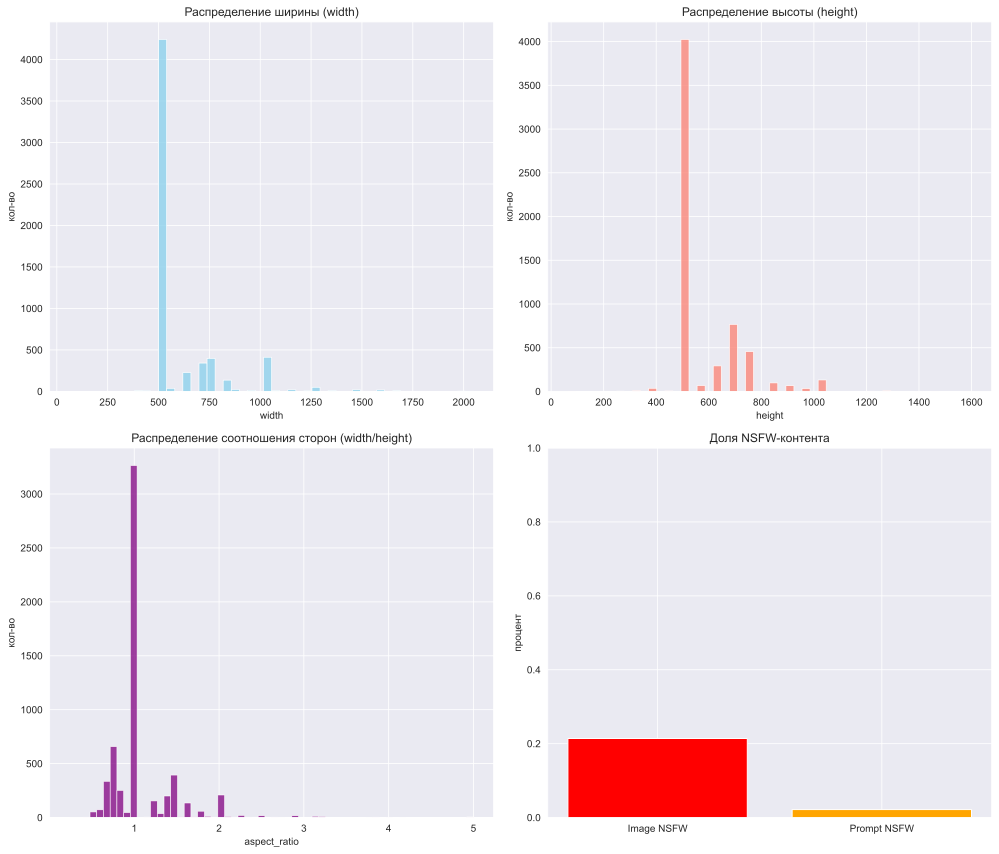

In [44]:
fig, axs = plt.subplots(2, 2, figsize=(14, 12))

sns.histplot(df["width"], bins=50, ax=axs[0,0], color="skyblue")
axs[0,0].set_title("Распределение ширины (width)")
axs[0,0].set_xlabel("width")
axs[0,0].set_ylabel("кол-во")

sns.histplot(df["height"], bins=50, ax=axs[0,1], color="salmon")
axs[0,1].set_title("Распределение высоты (height)")
axs[0,1].set_xlabel("height")
axs[0,1].set_ylabel("кол-во")

sns.histplot(df["aspect_ratio"], bins=60, ax=axs[1,0], color="purple")
axs[1,0].set_title("Распределение соотношения сторон (width/height)")
axs[1,0].set_xlabel("aspect_ratio")
axs[1,0].set_ylabel("кол-во")

nsfw_counts = {
    "Image NSFW": df["image_nsfw"].mean(),
    "Prompt NSFW": df["prompt_nsfw"].mean()
}

axs[1,1].bar(nsfw_counts.keys(), nsfw_counts.values(), color=["red", "orange"])
axs[1,1].set_ylim(0, 1)
axs[1,1].set_title("Доля NSFW-контента")
axs[1,1].set_ylabel("процент")

plt.tight_layout()
plt.show()

In [45]:
device = "cuda" if torch.cuda.is_available() else "cpu"

clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32").to(device)
clip_processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

In [46]:
def load_pil_image(image_field):
    if isinstance(image_field, dict):
        img = Image.open(image_field["path"])
    else:
        img = image_field

    if img.mode != "RGB":
        img = img.convert("RGB")
    return img

def get_image_emb(img):
    img = load_pil_image(img)
    inputs = clip_processor(images=img, return_tensors="pt").to(device)
    with torch.no_grad():
        return clip_model.get_image_features(**inputs).cpu().numpy().flatten()
    
def get_text_emb(text):
    inputs = clip_processor(
        text=[text],
        return_tensors="pt",
        padding=True,
        truncation=True,
        max_length=77
    ).to(device)

    with torch.no_grad():
        return clip_model.get_text_features(**inputs).cpu().numpy().flatten()


def cosine_sim(a, b):
    return np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b))

In [47]:
used_images = []
used_prompts = []
img_embs = []
txt_embs = []
scores = []

records = df.to_dict("records")

for item in tqdm(records, desc="Вычисление ручного CLIPScore (cosine)"):
    try:
        img_raw = item["image"]
        prompt = item["prompt"]

        img = load_pil_image(img_raw)
        e_img = get_image_emb(img)
        e_txt = get_text_emb(prompt)
        score = cosine_sim(e_img, e_txt)

        used_images.append(img)
        used_prompts.append(prompt)
        img_embs.append(e_img)
        txt_embs.append(e_txt)
        scores.append(score)
    except Exception as e:
        print("Ошибка на строке:", item["prompt"][:80], "...", "\nСообщение:", e)
        continue

Вычисление ручного CLIPScore (cosine): 100%|██████████| 6000/6000 [11:48<00:00,  8.47it/s]


In [48]:
X = np.hstack([img_embs, txt_embs])
y = np.array(scores)

In [49]:
n = len(X)
indices = np.arange(n)

idx_train, idx_prep, y_train, y_prep = train_test_split(
    indices,
    y,
    test_size=0.3,
    random_state=42
)
idx_val, idx_test, y_val, y_test = train_test_split(
    idx_prep,
    y_prep,
    test_size=0.5,
    random_state=42
)

X_train = X[idx_train]
X_val   = X[idx_val]
X_test  = X[idx_test]

print("Размеры:", X_train.shape, X_val.shape, X_test.shape)


Размеры: (4200, 1024) (900, 1024) (900, 1024)


In [50]:
LR_model2 = LinearRegression()
LR_model2.fit(X_train, y_train)
pred_lr2 = LR_model2.predict(X_val)

mae_lr2  = mean_absolute_error(y_val, pred_lr2)
rmse_lr2 = np.sqrt(mean_squared_error(y_val, pred_lr2))
r2_lr2   = r2_score(y_val, pred_lr2)

In [51]:
RF_model2 = RandomForestRegressor(
    n_estimators=200,
    n_jobs=-1,
    random_state=42
)
RF_model2.fit(X_train, y_train)
pred_rf2 = RF_model2.predict(X_val)

mae_rf2  = mean_absolute_error(y_val, pred_rf2)
rmse_rf2 = np.sqrt(mean_squared_error(y_val, pred_rf2))
r2_rf2   = r2_score(y_val, pred_rf2)

In [52]:
input_dim = X_train.shape[1]

class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Linear(128, 1)
        )
    def forward(self, x):
        return self.net(x)

mlp = MLP().to(device)
optimizer = optim.Adam(mlp.parameters(), lr=1e-3)
loss_fn = nn.MSELoss()

X_train_t = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train_t = torch.tensor(y_train, dtype=torch.float32).view(-1,1).to(device)

for epoch in range(5):
    mlp.train()
    optimizer.zero_grad()
    pred = mlp(X_train_t)
    loss = loss_fn(pred, y_train_t)
    loss.backward()
    optimizer.step()
    print("Epoch", epoch, "loss:", loss.item())

mlp.eval()
with torch.no_grad():
    pred_mlp = mlp(torch.tensor(X_val, dtype=torch.float32).to(device)).cpu().numpy().flatten()

mae_mlp  = mean_absolute_error(y_val, pred_mlp)
rmse_mlp = np.sqrt(mean_squared_error(y_val, pred_mlp))
r2_mlp   = r2_score(y_val, pred_mlp)

Epoch 0 loss: 0.13170088827610016
Epoch 1 loss: 0.005564952734857798
Epoch 2 loss: 0.0507332868874073
Epoch 3 loss: 0.008668067865073681
Epoch 4 loss: 0.004159091506153345


In [53]:
lgbm = lgb.LGBMRegressor(
    objective="regression",
    n_estimators=500,
    learning_rate=0.05,
    num_leaves=64,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1
)

lgbm.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    eval_metric="huber",
    callbacks=[lgb.log_evaluation(period=50)]
)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.047226 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 261120
[LightGBM] [Info] Number of data points in the train set: 4200, number of used features: 1024
[LightGBM] [Info] Start training from score 0.319918
[50]	valid_0's huber: 0.00046152	valid_0's l2: 0.00092304
[100]	valid_0's huber: 0.000435502	valid_0's l2: 0.000871004
[150]	valid_0's huber: 0.000428271	valid_0's l2: 0.000856543
[200]	valid_0's huber: 0.000425397	valid_0's l2: 0.000850794
[250]	valid_0's huber: 0.000423893	valid_0's l2: 0.000847787
[300]	valid_0's huber: 0.000422923	valid_0's l2: 0.000845846
[350]	valid_0's huber: 0.000422458	valid_0's l2: 0.000844915
[400]	valid_0's huber: 0.000422491	valid_0's l2: 0.000844983
[450]	valid_0's huber: 0.000422412	valid_0's l2: 0.000844824
[500]	valid_0's huber: 0.000422398	valid_0's l2: 0.000844796


,boosting_type,'gbdt'
,num_leaves,64
,max_depth,-1
,learning_rate,0.05
,n_estimators,500
,subsample_for_bin,200000
,objective,'regression'
,class_weight,None
,min_split_gain,0.0
,min_child_weight,0.001
,min_child_samples,20


In [54]:
y_val_pred = lgbm.predict(X_val)
lgbm_mae = mean_absolute_error(y_val, y_val_pred)
lgbm_rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))
lgbm_r2  = r2_score(y_val, y_val_pred)

c:\proging\pyfiles\MFDP\MFDP\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


In [55]:
baseline_pred = np.full_like(y_val, fill_value=y_train.mean())
baseline_mae = mean_absolute_error(y_val, baseline_pred)

def mase(mae):
    return mae / baseline_mae

results = [
    {
        "Модель": "Linear Regression (CLIP)",
        "MAE": mae_lr2,
        "RMSE": rmse_lr2,
        "R2":   r2_lr2,
        "MASE": mase(mae_lr2)
    },
    {
        "Модель": "Random Forest (CLIP)",
        "MAE": mae_rf2,
        "RMSE": rmse_rf2,
        "R2":   r2_rf2,
        "MASE": mase(mae_rf2)
    },
    {
        "Модель": "MLP (CLIP)",
        "MAE": mae_mlp,
        "RMSE": rmse_mlp,
        "R2":   r2_mlp,
        "MASE": mase(mae_mlp)
    },
    {
        "Модель": "LGBM (CLIP)",
        "MAE": lgbm_mae,
        "RMSE": lgbm_rmse,
        "R2":   lgbm_r2,
        "MASE": mase(lgbm_mae)
    }
]

df_metrics = pd.DataFrame(results).sort_values("MASE").reset_index(drop=True)
display(df_metrics)
print("Лучшая модель:", df_metrics.loc[0, "Модель"])

,Модель,MAE,RMSE,R2,MASE
0,LGBM (CLIP),0.022508,0.029065,0.510010,0.697955
1,Random Forest (CLIP),0.023807,0.030659,0.454799,0.738223
2,Linear Regression (CLIP),0.023909,0.031363,0.429494,0.741407
3,MLP (CLIP),0.108397,0.116798,-6.912344,3.361315


Лучшая модель: LGBM (CLIP)


## Готовая модель (CLIPScore)

In [56]:
clip_metric_ready = CLIPScore(model_name_or_path="openai/clip-vit-base-patch32").to(device)

In [57]:
to_tensor = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

In [58]:
warnings.filterwarnings(
    "ignore",
    message="It looks like you are trying to rescale already rescaled images",
    category=UserWarning
)
warnings.filterwarnings(
    "ignore",
    message="Encountered caption longer than max_position_embeddings=77. Will truncate captions to thislength.",
    category=UserWarning
)

In [59]:
test_images  = [used_images[i]  for i in idx_test]
test_prompts = [used_prompts[i] for i in idx_test]

In [60]:
y_true_clip = []

for img, prompt in tqdm(zip(test_images, test_prompts),
                        total=len(test_images),
                        desc="CLIPScore (torchmetrics) на тесте"):
    img_t = to_tensor(img).unsqueeze(0).to(device)
    with torch.no_grad():
        score = clip_metric_ready(img_t, [prompt]).item()
    y_true_clip.append(score)

y_true_clip = np.array(y_true_clip)

CLIPScore (torchmetrics) на тесте: 100%|██████████| 900/900 [03:15<00:00,  4.60it/s]


In [61]:
y_pred_lgbm = lgbm.predict(X_test)

clip_mae  = mean_absolute_error(y_true_clip, y_pred_lgbm)
clip_rmse = np.sqrt(mean_squared_error(y_true_clip, y_pred_lgbm))
clip_r2   = r2_score(y_true_clip, y_pred_lgbm)

c:\proging\pyfiles\MFDP\MFDP\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


In [62]:
baseline_mean_clip = y_true_clip.mean()
baseline_pred_clip = np.full_like(y_true_clip, fill_value=baseline_mean_clip, dtype=float)
baseline_mae_clip  = mean_absolute_error(y_true_clip, baseline_pred_clip)

clip_mase = clip_mae / baseline_mae_clip

print("LGBM на тестовой выборке")
print(f"MAE: {clip_mae:.4f}")
print(f"RMSE: {clip_rmse:.4f}")
print(f"R2: {clip_r2:.4f}")
print(f"MASE: {clip_mase:.4f}")

print("CLIPScore ( torchmetrics):")
print("min:", y_true_clip.min())
print("max:", y_true_clip.max())
print("mean:", y_true_clip.mean())

LGBM на тестовой выборке
MAE: 18.5955
RMSE: 18.8449
R2: -37.1376
MASE: 7.7333
CLIPScore ( torchmetrics):
min: 10.626409530639648
max: 29.969104766845703
mean: 18.91467180781894


In [63]:
y_old = y_test
y_new = y_true_clip

mae_old_new = mean_absolute_error(y_old, y_new)
rmse_old_new = np.sqrt(mean_squared_error(y_old, y_new))
r2_old_new = r2_score(y_old, y_new)

baseline_mean_old = y_old.mean()
baseline_pred_old = np.full_like(y_old, fill_value=baseline_mean_old, dtype=float)
baseline_mae_old = mean_absolute_error(y_old, baseline_pred_old)
mase_old_new = mae_old_new / baseline_mae_old

print("Сравнение CLIPScore (cosine) и CLIPScore (torchmetrics) ")
print(f"MAE (old vs new): {mae_old_new:.4f}")
print(f"RMSE (old vs new): {rmse_old_new:.4f}")
print(f"R2 (old vs new): {r2_old_new:.4}")
print(f"MASE (old vs new): {mase_old_new:.4f}")


Сравнение CLIPScore (cosine) и CLIPScore (torchmetrics) 
MAE (old vs new): 18.5942
RMSE (old vs new): 18.8436
R2 (old vs new): -2.137e+05
MASE (old vs new): 600.0351


## Анализ результатов

### EDA

Для оценки соответствия изображений их текстовым промтам был использован датасет `poloclub/diffusiondb` (конфигурация `2m_first_10k`). Из него были случайно выбраны 6000 объектов.

#### Основные наблюдения

1. Самые частые изображения квадратные (соотношение сторон 1:1), самый частый размер это 512×512px. Вероятнее всего это связано с форматом генерации Stable Diffusion (квадратный фрормат изображения).

2. NSFW-контент
   - Средняя доля NSFW по картинкам - около 20%
   - Средняя доля NSFW по текстам - около 2%
   
Думаю, что такая сильная разница объясняется тем, что модели классификации NSFW для изображений работают строже или промт может быть невинным, но модель генерации может интерпретировать его как NSFW запрос (промт girl может приводит к NSFW-контенту).

---

### Сравнение моделей

|Модель|MAE|RMSE|R²|MASE|
|-|-|-|-|-|
|LGBM (CLIP)|0.0225|0.0291|0.5100|0.698|
|Random Forest (CLIP)|0.0238|0.0307|0.4548| 0.738|
|Linear Regression (CLIP)|0.0239|0.0314|-0.2627| 0.741|
|MLP (CLIP)|0.0744|0.0838|-3.068|2.308|

#### Почему такие результаты?

##### 1) **Linear Regression (CLIP)**
Простая линейная модель даёт ожидаемо базовый результат. CLIP-эмбеддинги содержат сложные нелинейные связи, поэтому линейные модели не могут раскрыть весь их потенциал.

##### 2) **Random Forest (CLIP)**
Справляется лучше, чем линейная модель, благодаря учёту нелинейных связей, устойчивости к шуму и хорошей работе с высокоразмерными табличными признаками.

##### 3) **MLP (CLIP)**
Работает значительно хуже всех остальных моделей. Т.к. данных недостаточно для нейросети (6000 объектов - мало) и отсутствие глубокой архитектуры или сильной регуляризации. Модель переобучается, что видно по **MASE > 2** и отрицательному R².

##### 4) **LGBM (CLIP)** - лучший результат
Модель градиентного бустинга по деревьям лучше всего работает на табличных данных с высокой размерностью, устойчивее к шуму, чем MLP, а так же обучается быстрее и проще по железу, чем нейросети.

---

## Сравнение с готовым CLIPScore (torchmetrics)

Помимо моделей, обученных предсказывать "ручной" CLIPScore (cosine между эмбеддингами изображения и текста), я добавил стандартную реализацию метрики:

- `CLIPScore` из `torchmetrics` (`model_name_or_path="openai/clip-vit-base-patch32"`).

Для честного сравнения:

1. Я разделил данные на train/val/test и обучал LGBM предсказывать **cosine-CLIPScore**.
2. На той же тестовой выборке посчитал:
   - предсказания LGBM;
   - "эталонный" CLIPScore из `torchmetrics`.

И далее посчитал **MAE/RMSE/R²/MASE между ними**:

- LGBM vs готовый CLIPScore (torchmetrics):

  - MAE ≈ **18.60**
  - RMSE ≈ **18.84**
  - R² ≈ **-37.14**
  - MASE ≈ **7.73**

При этом сами значения CLIPScore (torchmetrics) лежат в диапазоне:

- **min ≈ 10.6**
- **max ≈ 30.0**
- **mean ≈ 18.9**

То есть:

- Ошибка LGBM по отношению к готовому CLIPScore сопоставима с самим уровнем метрики.
- Отрицательный R² и MASE >> 1 означают, что модель хуже, чем константа, если брать готовый CLIPScore как "истинное" значение.

Это ожидаемо, потому что:

- LGBM обучался предсказывать совершенно другую величину - обычный cosine в диапазоне [-1, 1].
- Готовый CLIPScore использует другую формулу и шкалу, заточенную под более интерпретируемые значения и корректную нормализацию.

---

### Сравнение старого и нового CLIPScore

Я отдельно сравнил:

- `y_old` - CLIPScore cosine;
- `y_new` - CLIPScore из `torchmetrics`.

Результаты:

- MAE(old vs new) ≈ **18.59**
- RMSE(old vs new) ≈ **18.84**
- R²(old vs new) неимоверно отрицательный
- MASE(old vs new) ≫ 1

Вывод:

Это по факту 2 абсолютно разные метрики в разных шкалах, а не одна и та же метрика с небольшой погрешностью, поэтому нельзя интерпретировать эти числа как реализация сильно хуже/лучше эталонной - она просто считает другую величину.

---

## Почему используется MASE как сводная метрика

В задаче предсказания CLIPScore таргет находится в узком диапазоне, а baseline-константа (среднее значение) сама по себе даёт неплохой результат, поэтому важно оценить, насколько модель лучше, чем просто предсказывать среднее.

Для этого используется **MASE** ведь, если **MASE < 1** модель лучше baseline Если **MASE > 1**, модель хуже (выдачи среднего).

## Итог 

Согласно MAE/RMSE/MASE/R²:

1. **ML-бейслайн**  
   - LGBM по CLIP-эмбеддингам хорошо предсказывает cosine между эмбеддингами.
   - Внутри этой метрики LGBM - лучшая модель (MASE < 1, R² ≈ 0.51).

2. **Эталонная метрика**  
   - Для реального продукта разумно использовать готовый CLIPScore (torchmetrics):
     - он не требует обучения,
     - реализует стандарт из статьи CLIPScore,
     - сразу работает в удобной шкале.

---

## Связь с продуктом

В AI-продукте эта модель будет использоваться как часть модуля судьи, который:

- оценивает соответствие изображения текстовому описанию
- будет ранжировать сгенерированные изображения
- автоматически выбореть лучший результат в режиме для SMM/малого бизнеса

В сочетании с моделью эстетики LGBM по CLIPScore формирует основу интеллектуального модуля выбора изображения в MVP.